# Problem statement:

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.


Build a multiclass classification model using a custom convolutional neural network in TensorFlow.

## <font color='Brown'> Importing Skin Cancer Data </font>
#### Step 1:- Importing all the important libraries

In [1]:
#import the required libraries
import pathlib
import os, cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D

import warnings
warnings.filterwarnings("ignore")

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

## Data set Ref : https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [3]:
#unziping the dataset
!unzip "/content/gdrive/MyDrive/CNN_assignment.zip" > /dev/null

## <font color='Brown'>Reading Data and Understanding it</font>
#### Step 2:- Defining the path for train and test images

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.


In [4]:
# Defining the path for train and test images,
dataset_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
dataset_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test")


In [5]:
# Training Image Count
image_count_train = len(list(dataset_train.glob('*/*.jpg')))
print(image_count_train)

2239


In [6]:
# Testing Image Count
image_count_test = len(list(dataset_test.glob('*/*.jpg')))
print(image_count_test)

118


## <font color='Brown'> Load using keras.preprocessing</font>

#### Step 3:- Let's load these images off disk using the helpful image_dataset_from_directory utility.

In [7]:
# Defined some parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

<font color='Green'> Note:- Here we are using 80% of the images for training, and 20% for validation.

In [8]:
# Loading the training data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(dataset_train,
                                                               seed=123,
                                                               validation_split=0.2,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size,
                                                               color_mode='rgb',
                                                               subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
# Loading the validation data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(dataset_train,
                                                             seed=123,
                                                             validation_split=0.2,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb',
                                                             subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# Loading the testing data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(dataset_test,
                                                             seed=123,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb')

Found 118 files belonging to 9 classes.


#### <font color = 'blue'>Here we are listing out all the classes of skin cancer and store them in a list.

In [11]:
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## <font color='Brown'>Visualize the data</font>
### <font color='magenta'>Step 4:- Todo, create a code to visualize one instance of all the nine classes present in the dataset

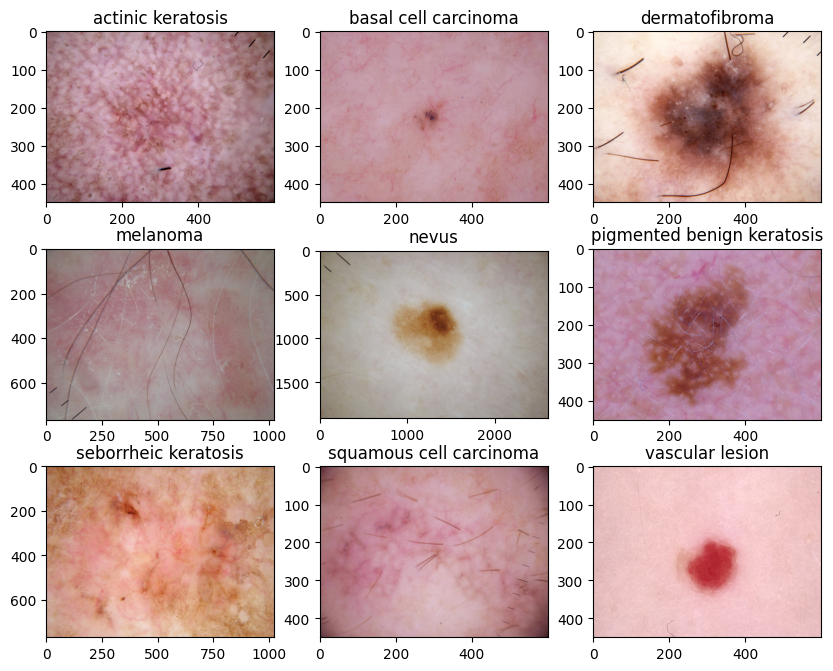

In [12]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10,8))
for i in range(len(class_names)):
  plt.subplot(3,3,i+1)
  image= plt.imread(str(list(dataset_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
# Configuing the dataset for the performance

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# `Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.\
# `Dataset.prefetch()` overlaps data preprocessing and model execution while training.

## <font color='Brown'>Creating a Model</font>
#### <font color='green'> Note:- Creating a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

## <font color='Red'> Model 1</font>
### <font color='Brown'> Step 5:- Model Building & training :</font>

#### <font color='navybkue'> Step i : Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).</font>
#### <font color='navybkue'> Step ii : Choosing an appropriate optimiser and loss function for model training.</font>
#### <font color='navybkue'> Step iii : Training the model for ~20 epochs.</font>
#### <font color='navybkue'> Step iv : Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.</font>

In [14]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [15]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 259200)            0

In [16]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 30s 119ms/step - loss: 3.6686 - accuracy: 0.2271 - val_loss: 2.1130 - val_accuracy: 0.2975
Epoch 2/20
56/56 [==============================] - 4s 66ms/step - loss: 1.8029 - accuracy: 0.3599 - val_loss: 1.6467 - val_accuracy: 0.4206
Epoch 3/20
56/56 [==============================] - 4s 67ms/step - loss: 1.5229 - accuracy: 0.4526 - val_loss: 1.5535 - val_accuracy: 0.4698
Epoch 4/20
56/56 [==============================] - 4s 67ms/step - loss: 1.4124 - accuracy: 0.5123 - val_loss: 1.7493 - val_accuracy: 0.4698
Epoch 5/20
56/56 [==============================] - 4s 67ms/step - loss: 1.2951 - accuracy: 0.5469 - val_loss: 1.4310 - val_accuracy: 0.5615
Epoch 6/20
56/56 [==============================] - 4s 67ms/step - loss: 1.1781 - accuracy: 0.5809 - val_loss: 1.6459 - val_accuracy: 0.4922
Epoch 7/20
56/56 [==============================] - 4s 68ms/step - loss: 1.0319 - accuracy: 0.6278 - val_loss: 1.6226 - val_accuracy: 0.5257
Epoch 8/20


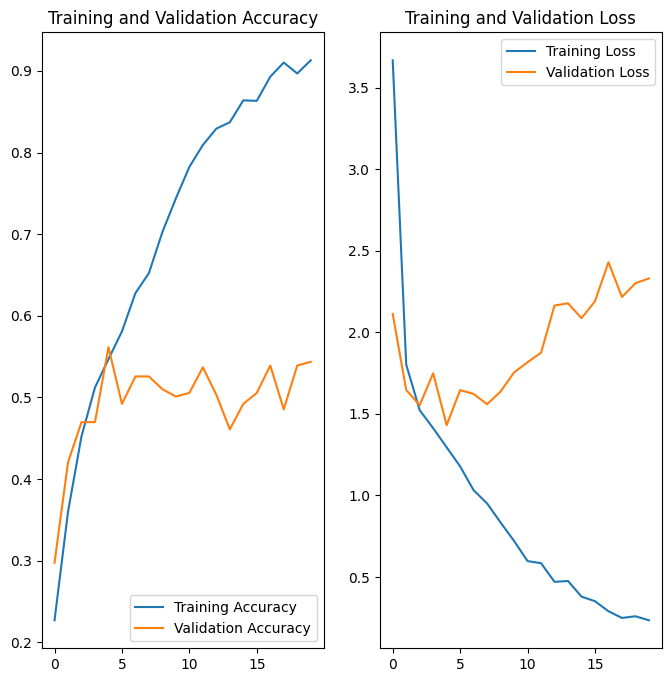

In [17]:
#Plotting the graph of outcome
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### Findings from the Graph:
- As the training accuracy increases linearly over time, where as the validation accuracy stall at ~54% accuracy in training process.
- As the training loss dereases with epochs the validation loss increases
- The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved around <b>~54%</b> accuracy on the validation set.
- The difference in accuracy between training and validation accuracy is <b>noticeable</b> which is a sign of overfitting.

## <font color='Brown'>Choosing an appropriate data augmentation strategy to resolve underfitting/overfitting</font>

#### <font color='green'>Note:- Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

In [18]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

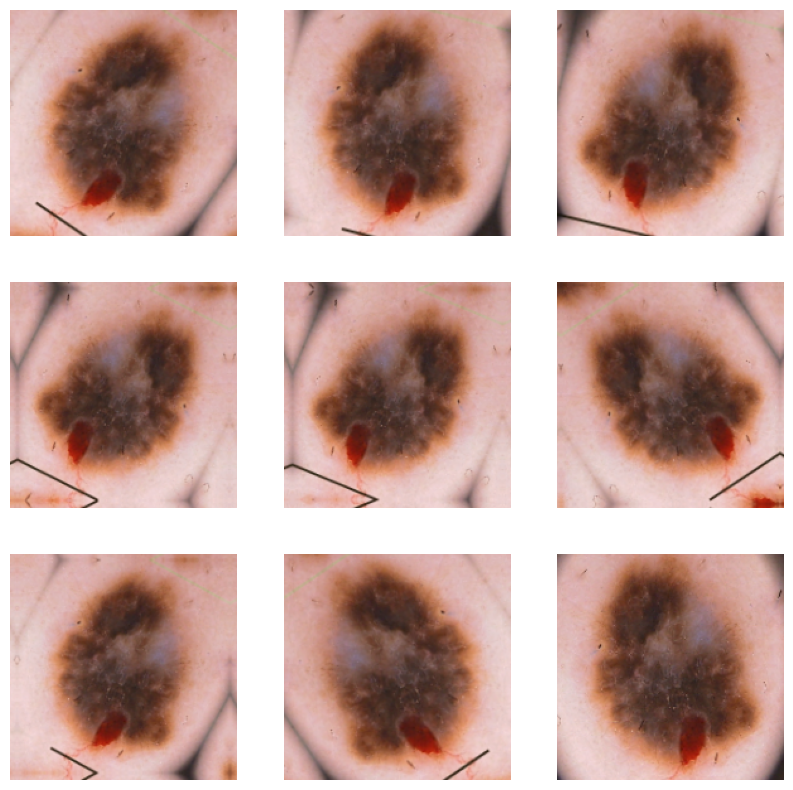

In [19]:
# visualizing how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## <font color='Red'> Model 2</font>
## <font color='Brown'>Step 6:- Model Building & training on the augmented data :</font>

#### <font color='navyblue'>Step i :Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).</font>
#### <font color='navyblue'>Step ii :Choosing an appropriate optimiser and loss function for model training.</font>
#### <font color='navyblue'>Step iii :Training the model for ~20 epochs.</font>
#### <font color='navyblue'>Step iv :Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.</font>

In [20]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# adding the augmentation layer before the convolution layer
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [21]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 90, 90, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 45, 45, 128)       0         
 g2D)                                                 

In [22]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 6s 73ms/step - loss: 3.4813 - accuracy: 0.2204 - val_loss: 1.8785 - val_accuracy: 0.3132
Epoch 2/20
56/56 [==============================] - 4s 69ms/step - loss: 1.7863 - accuracy: 0.3460 - val_loss: 2.0024 - val_accuracy: 0.3490
Epoch 3/20
56/56 [==============================] - 4s 72ms/step - loss: 1.6703 - accuracy: 0.3895 - val_loss: 1.5889 - val_accuracy: 0.4139
Epoch 4/20
56/56 [==============================] - 4s 70ms/step - loss: 1.5283 - accuracy: 0.4576 - val_loss: 1.4816 - val_accuracy: 0.4922
Epoch 5/20
56/56 [==============================] - 4s 70ms/step - loss: 1.4496 - accuracy: 0.4860 - val_loss: 1.5125 - val_accuracy: 0.4497
Epoch 6/20
56/56 [==============================] - 4s 71ms/step - loss: 1.3934 - accuracy: 0.5073 - val_loss: 1.3750 - val_accuracy: 0.5280
Epoch 7/20
56/56 [==============================] - 4s 69ms/step - loss: 1.3080 - accuracy: 0.5340 - val_loss: 1.3912 - val_accuracy: 0.5168
Epoch 8/20
56

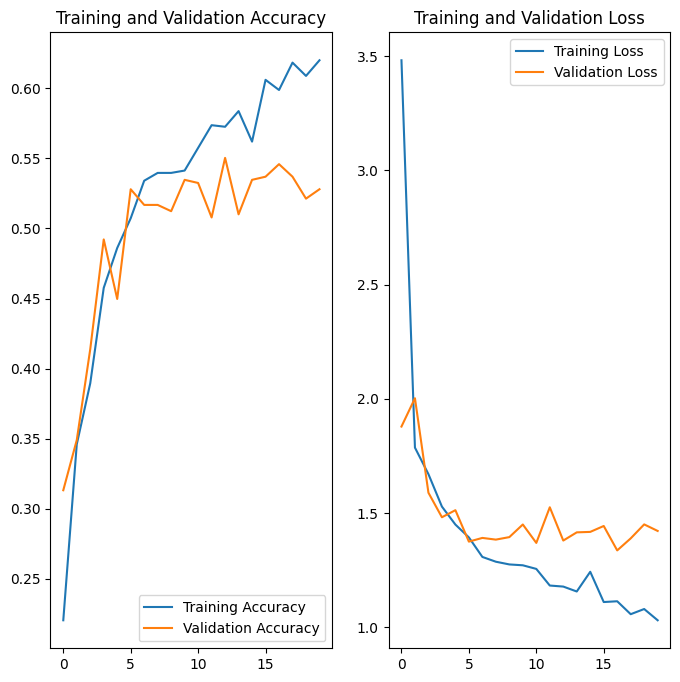

In [23]:
#plotting the graph of outcome
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### Findings from the graph:
- As the training accuracy increases linearly over time, where as the validation accuracy increases and stall at ~52% accuracy in training process.
- As the training loss decreases with epochs the validation loss decreases and stalls.
- The plots show that gap between training accuracy and validation accuracy have decreased from previous model, and it has achieved around <b>~52%</b> accuracy on the validation set.
- The difference in accuracy between training and validation accuracy is still <b>slightly noticeable</b> which is a sign of overfitting.

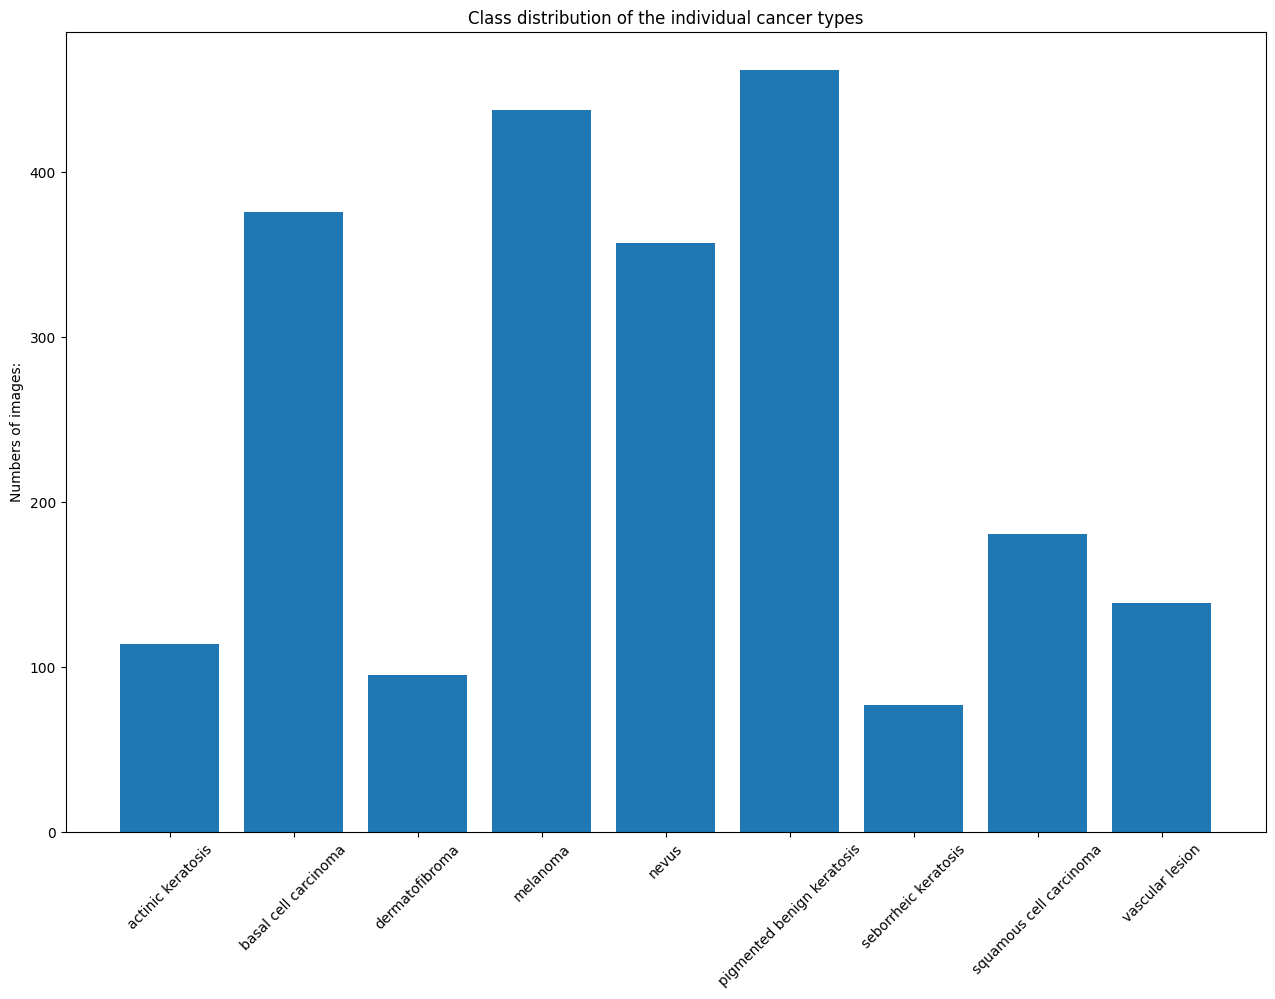

In [24]:
# Plot the images to check if all the cancer types are equally distributed
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0,0,1,1])
x=[]
y=[]
for i in range(len(class_names)):
  x.append(class_names[i])
  y.append(len(list(dataset_train.glob(class_names[i]+'/*.jpg'))))

ax.bar(x,y)
ax.set_ylabel('Numbers of images:')
ax.set_title('Class distribution of the individual cancer types')
plt.xticks(rotation=45)
plt.show()

## <font color='Red'> Model 3</font>
## <font color = 'brown'>Step 7:- Model Building & training on the augmented data with dropout :</font>

#### <font color = 'navyblue'> Step i : Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).</font>
#### <font color = 'navyblue'> Step ii :Choosing an appropriate optimiser and loss function for model training.</font>
#### <font color = 'navyblue'> Step iii :Training the model for ~20 epochs.</font>
#### <font color = 'navyblue'> Step iv :Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.</font>

In [25]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())
#adding a 20% dropout after the convolution layers
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [26]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 90, 90, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 45, 45, 128)       0         
 g2D)                                                 

In [27]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 8s 117ms/step - loss: 3.2003 - accuracy: 0.1925 - val_loss: 2.0524 - val_accuracy: 0.1902
Epoch 2/20
56/56 [==============================] - 6s 112ms/step - loss: 2.0077 - accuracy: 0.2260 - val_loss: 1.9569 - val_accuracy: 0.2864
Epoch 3/20
56/56 [==============================] - 6s 112ms/step - loss: 2.0182 - accuracy: 0.2489 - val_loss: 1.9144 - val_accuracy: 0.2886
Epoch 4/20
56/56 [==============================] - 6s 110ms/step - loss: 1.8440 - accuracy: 0.2829 - val_loss: 1.7105 - val_accuracy: 0.4295
Epoch 5/20
56/56 [==============================] - 6s 112ms/step - loss: 1.7119 - accuracy: 0.3783 - val_loss: 1.7272 - val_accuracy: 0.4072
Epoch 6/20
56/56 [==============================] - 6s 112ms/step - loss: 1.6448 - accuracy: 0.4079 - val_loss: 1.6728 - val_accuracy: 0.4183
Epoch 7/20
56/56 [==============================] - 6s 112ms/step - loss: 1.5662 - accuracy: 0.4526 - val_loss: 1.5137 - val_accuracy: 0.4787
Epoch 

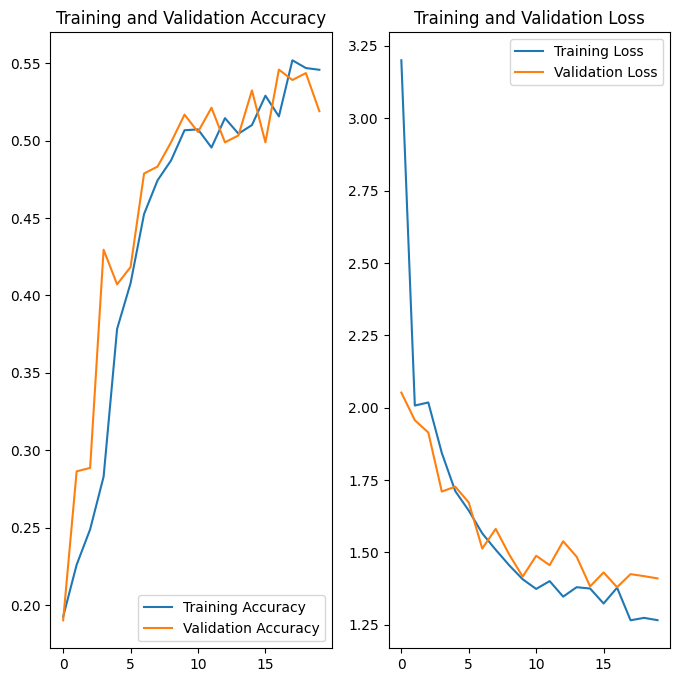

In [28]:
#plotting the graph of outcome
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### Findings from the graph:
- As the training accuracy increases linearly over time, where as the validation accuracy increases and stall at ~51% accuracy in training process.
- <b>As the training loss decreases with epochs the validation loss decreases</b>
- The plots show that gap between training accuracy and validation accuracy have decreased from previous model, and it has achieved around <b>~51%</b> accuracy on the validation set.
- The difference in accuracy between training and validation accuracy is <b>very less</b>

### <font color = 'Pink'>Observation :- **We can clearly see that the overfitting of the model has redused significantly when compared the earlier models.**

### <font color = 'Magenta'>Step 8:- **Todo:** Find the distribution of classes in the training dataset.</font>
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

# Class distribution:

Examining the current class distribution in the training dataset

Datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others.

Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [29]:
for i in range(len(class_names)):
  print(class_names[i],' - ',len(list(dataset_train.glob(class_names[i]+'/*.jpg'))))

actinic keratosis  -  114
basal cell carcinoma  -  376
dermatofibroma  -  95
melanoma  -  438
nevus  -  357
pigmented benign keratosis  -  462
seborrheic keratosis  -  77
squamous cell carcinoma  -  181
vascular lesion  -  139



### <font color = 'Magenta'>Step 9:- **Todo:** Write your findings here:</font>
### - <b>Which class has the least number of samples?</b>
#### - <font color = 'red'><b>Seborrheic keratosis </b></font>has the least number with 77 samples.

### - <b>Which classes dominate the data in terms proportionate number of samples?</b>
#### - <font color = 'red'><b>pigmented benign keratosis</b></font> dominates with 462 samples in total.


## <font color = 'Brown'>Step 10 :- Handling class imbalances:</font>

Rectifing class imbalances present in the training dataset with Augmentor library.

In [30]:
!pip install Augmentor

In [31]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
   p = Augmentor.Pipeline(path_to_training_dataset + i)
   p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
   p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B75ED364580>: 100%|██████████| 500/500 [00:16<00:00, 29.66 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B76746C3A60>: 100%|██████████| 500/500 [00:19<00:00, 26.27 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7B75ED39F4F0>: 100%|██████████| 500/500 [00:21<00:00, 23.26 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7B75ED124070>: 100%|██████████| 500/500 [01:22<00:00,  6.09 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7B75ED2106A0>: 100%|██████████| 500/500 [01:29<00:00,  5.57 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B75ED3821D0>: 100%|██████████| 500/500 [00:18<00:00, 26.94 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7B75ED41F910>: 100%|██████████| 500/500 [00:40<00:00, 12.39 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7B75ED2FA0E0>: 100%|██████████| 500/500 [00:14<00:00, 33.98 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7B75ED27C1F0>: 100%|██████████| 500/500 [00:15<00:00, 32.59 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [32]:
dataset_train =("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")

### <font color = 'Magenta'>Lets see the distribution of augmented data after adding new images to the original training data.

In [33]:
from glob import glob
path_list = [x for x in glob(os.path.join(dataset_train, '*', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(dataset_train, '*', '*.jpg'))]

In [34]:
dict_new = dict(zip(path_list, lesion_list_new))
df = pd.DataFrame(list(dict_new.items()),columns = ['Path','Label'])

#### <font color = 'Green'>Note:- So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [35]:
# initializing the parameter to load the images
batch_size = 32
img_height = 180
img_width = 180

In [36]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### <font color = 'Green'>Note:- So here we can see we have added around 4500 new images using augmentor. So now the total no of images are 4500 + 2239 = 6739 images

In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


## <font color='Red'> Model 4</font>
## <font color = 'Brown'>Step 11:- Model Building & training on the rectified class imbalance data :</font>

#### <font color = 'navyblue'>Step i : Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).</font>
#### <font color = 'navyblue'>Step ii : Choosing an appropriate optimiser and loss function for model training.</font>
#### <font color = 'navyblue'>Step iii : Training the model for ~30 epochs.</font>
#### <font color = 'navyblue'>Step iv : Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.</font>

In [38]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
#model.add(BatchNormalization())
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
#model.add(BatchNormalization())
model.add(layers.MaxPooling2D())
#adding a 20% dropout after the convolution layers
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [39]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 128)       0         
 g2D)                                                 

In [40]:
# Training the model
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 45s 252ms/step - loss: 2.3659 - accuracy: 0.2546 - val_loss: 1.5766 - val_accuracy: 0.4031
Epoch 2/30
169/169 [==============================] - 31s 178ms/step - loss: 1.5978 - accuracy: 0.4011 - val_loss: 1.4744 - val_accuracy: 0.4454
Epoch 3/30
169/169 [==============================] - 32s 183ms/step - loss: 1.4436 - accuracy: 0.4572 - val_loss: 1.4222 - val_accuracy: 0.4662
Epoch 4/30
169/169 [==============================] - 31s 179ms/step - loss: 1.3588 - accuracy: 0.4889 - val_loss: 1.2965 - val_accuracy: 0.5197
Epoch 5/30
169/169 [==============================] - 36s 210ms/step - loss: 1.2875 - accuracy: 0.5087 - val_loss: 1.2858 - val_accuracy: 0.5160
Epoch 6/30
169/169 [==============================] - 30s 175ms/step - loss: 1.2419 - accuracy: 0.5328 - val_loss: 1.2797 - val_accuracy: 0.5234
Epoch 7/30
169/169 [==============================] - 31s 177ms/step - loss: 1.2016 - accuracy: 0.5458 - val_loss: 1.2382 - val_ac

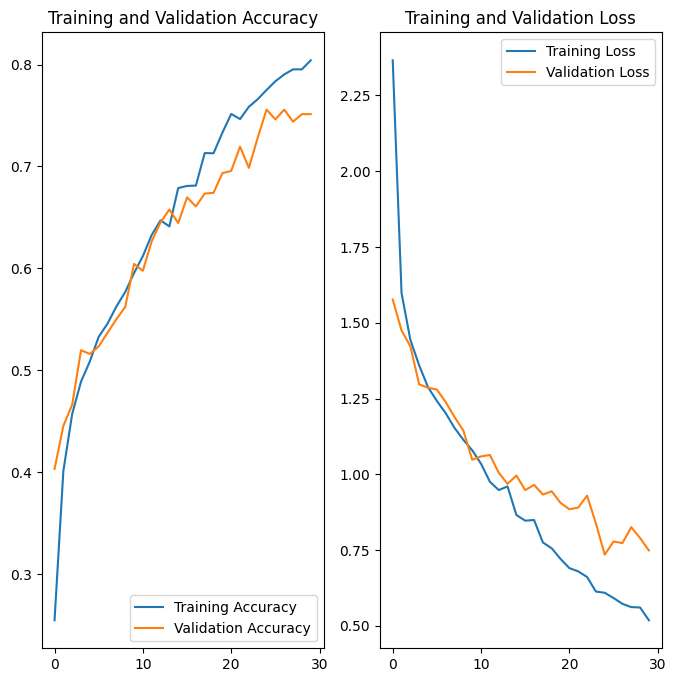

In [41]:
# Visualizing model results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## <font color = 'Brown'>Conclusion from the above analysis </font>

### - The training accuracy increases linearly over time, where as the validation accuracy increases in training process.
### - The training loss decreases with epochs, where as the validation loss also decreases with epochs.
### - The plots show that gap between training accuracy and validation accuracy have decreased significantly from previous model.
### - The difference in accuracy between training and validation accuracy is very less.
### - After training the model for around 50 epochs, the following results were achieved:
### <ol>
### <li>Training Accuracy: <font color = 'red'><b>~80%</b></font></li>
### <li>Validation Accuracy: <font color = 'red'><b>~75%</b></font></li>
### <li>Training Loss: <font color = 'red'><b>0.5</b></font></li>
### <li>Validation Loss: <font color = 'red'><b>0.7</b></font></li>
### </ol>


### <font color = 'Green'> Note :- Class rebalancing not only got rid of overfitting it also improved the accuracy from ~54% to ~80%.